In [ ]:
from numpy import array
from sympy import symbols, Eq, Matrix, diff, Derivative, simplify, factor, expand, latex, init_printing, collect
init_printing()
from IPython.display import display, Math

# General Procedure
The stiffness matrix [K] for an MITC4 element is defined using Equation 5.27 of Reference 1 (all references are listed at the bottom of this notebook):

$[k] = \int_A [B]^T[C][B] dA$

This integral will be extremely complex, so integration over the area (A) of the element will be carried out numerically using a procedure called Gaussian Quadrature as outlined in Reference 3 Section 10.4. The greatest difficulty in deriving this element is in coming up with the [B] matrix.

The equation for [k] above will need to be evaluated for bending, shear, and membrane forces separately. The resulting [k] matrices will then be summed to obtain the overall stiffness:

$[k] = [k_\kappa] + [k_\gamma] + [k_m]$

# Step 1: Define the Interpolation Functions
To obtain the [B] matrix, we'll need to define what are known as interpolation functions. Their purpose will become clear below. The interpolation functions are given in Figure 5.4 of Reference 1:

<div>
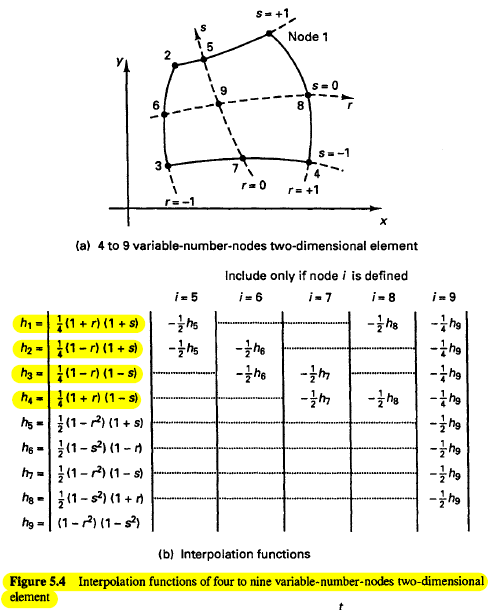
</div>

In [ ]:
x1, y1, x2, y2, x3, y3, x4, y4 = symbols('x_1, y_1, x_2, y_2, x_3, y_3, x_4, y_4')
r, s = symbols('r, s')

# Define the interpolation functions
h1 = factor(1/4*(1+r)*(1+s))
h2 = factor(1/4*(1-r)*(1+s))
h3 = factor(1/4*(1-r)*(1-s))
h4 = factor(1/4*(1+r)*(1-s))

display(Math('h_1 = ' + latex(h1)))
display(Math('h_2 = ' + latex(h2)))
display(Math('h_2 = ' + latex(h3)))
display(Math('h_2 = ' + latex(h4)))

# Step 2: Relate the (x, y) Local Coordinate System to the (r, s) Natural Coordinate System
MITC4 elements use 2 coordinate systems shown in Figure 5.26 of Reference 1. The natural coordinate system has its origin at the plate's centroid where r = 0 and s = 0, and goes from -1 to 1 along each axis. For example (r, s) = (-1, -1) is the bottom left corner of the plate. (r, s) = (1, 0) is the center of the right edge of the plate. Using the (r, s) system greatly simplifies integration over the volume of the plate. The interpolation functions are used to relate (or map) the real world (x, y) system to the natural (r, s) system using Equation 5.18 of Reference 1:

$x = \sum \limits _{i=1} ^{4} {h_ix_i}$ &emsp; &emsp; $y = \sum \limits _{i=1} ^{4} {h_iy_i}$

<div>
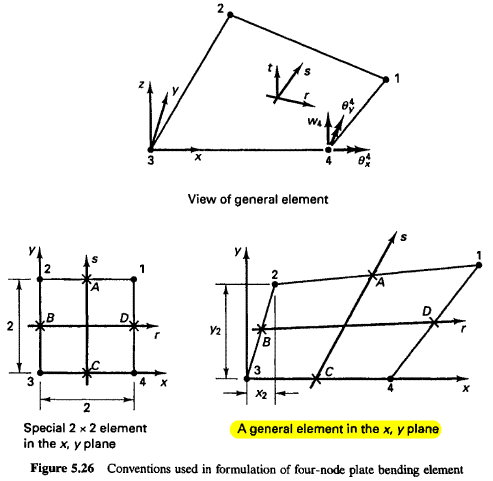
</div>

In [ ]:
x = h1*x1 + h2*x2 + h3*x3 + h4*x4
y = h1*y1 + h2*y2 + h3*y3 + h4*y4

display(Math('x = ' + latex(x)))
display(Math('y = ' + latex(y)))

# Step 3: Find the Jacobian Matrix
The Jacobian matrix converts derivatives with respect to x and y into derivatives with respect to r and s. It will be used for deriving the $[B]$ matrix. It should also be noted that he term $dA$ in the equation for $[k]$ above can be rewritten as:

$dA = |J|*dr*ds$

$J = \begin{bmatrix} \frac{dx}{dr} & \frac{dy}{dr} \\ \frac{dx}{ds} & \frac{dy}{ds} \end{bmatrix}$

In [ ]:
J = Matrix([[diff(x, r), diff(y, r)],
            [diff(x, s), diff(y, s)]])

display(Math('J = ' + latex(factor(J))))

# Step 4: Find the $[B]$ Matrix for Bending

The plate curvatures are shown in Reference 1 Figure 5.25.

<div>
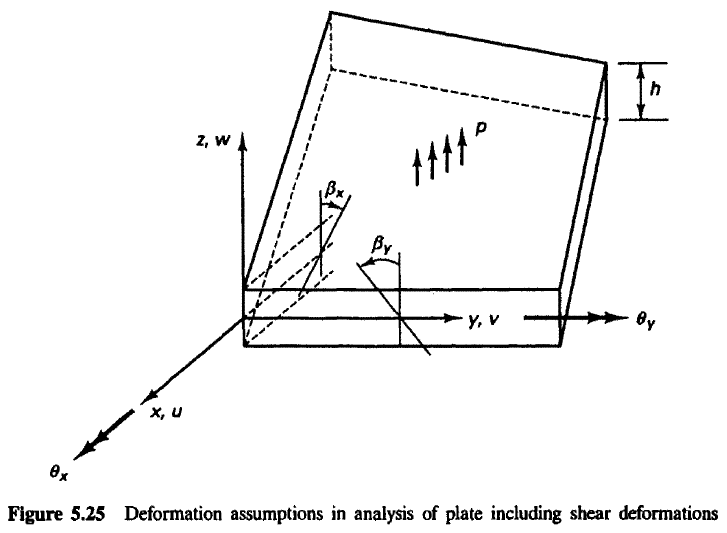
</div>

These curvatures can be obtained from Equation 5.99, which uses the interpolation functions and the nodal rotations to define curvature. We will also need the derivatives of these curvatures:

$\beta_x = -\sum \limits_{i=1}^{4} h_i \theta_y^i$ &ensp; $\therefore$ &ensp; $\frac{d\beta_x}{dx} = -\sum \limits_{i=1}^{4}\frac{dh_i}{dx}\theta_y^i$  &ensp; and &ensp; $\frac{d\beta_x}{dy} = -\sum \limits_{i=1}^{4}\frac{dh_i}{dy}\theta_y^i$

$\beta_y = \sum \limits_{i=1}^{4} h_i \theta_x^i$ &ensp; $\therefore$ &ensp; $\frac{d\beta_y}{dy} = \sum \limits_{i=1}^{4}\frac{dh_i}{dy}\theta_x^i$  &ensp; and &ensp; $\frac{d\beta_y}{dx} = \sum \limits_{i=1}^{4}\frac{dh_i}{dx}\theta_x^i$

Using Reference 1 Equation 5.95 we can establish the relationship below:

$[\kappa] = \begin{bmatrix} \frac{d\beta_x}{dx} \\ \frac{d\beta_y}{dy} \\ \frac{d\beta_x}{dy} + \frac{d\beta_y}{dx}\end{bmatrix} = [B_\kappa][d] = \begin{bmatrix} 0 & 0 & -\frac{h_1}{dx} & 0 & 0 & -\frac{h_2}{dx} & ... \\ 0 & \frac{h_1}{dy} & 0 & 0 & \frac{h_2}{dy} & 0 & ... \\ 0 & \frac{h_1}{dx} & -\frac{h_1}{dy} & 0 & \frac{h_2}{dx} & -\frac{h_2}{dy} & ... \end{bmatrix} \begin{bmatrix} w_1 \\ \theta_{x1} \\ \theta_{y1} \\ w_2 \\ \theta_{x2} \\ \theta_{y2} \\ . \\ . \\ . \end{bmatrix}$

Using the Jacobian matrix as shown in Reference 1, Equation 5.25, we can change these derivatives with respect to x and y into derivatives with respect to r and s.

$\begin{bmatrix} \frac{d}{dx} \\ \frac{d}{dy} \end{bmatrix} = J^{-1} \begin{bmatrix} \frac{d}{dr} \\ \frac{d}{ds} \end{bmatrix}$

In [ ]:
B_kappa = Matrix([[0,      0,      -diff(h1, r), 0,      0,      -diff(h2, r), 0,      0,      -diff(h2, r), 0,      0,      -diff(h4, r)],
                  [0, diff(h1, s),       0,      0, diff(h2, s),       0,      0, diff(h3, s),       0,      0, diff(h4, s),       0     ],
                  [0, diff(h1, r), -diff(h1, s), 0, diff(h2, r), -diff(h2, s), 0, diff(h3, r), -diff(h3, s), 0, diff(h4, r), -diff(h4, s)]])

display(Math('B_\kappa = J^{-1}(1/4)' + latex(B_kappa*4)))

# Find the [$B_m$] Matrix for In-Plane Force

In [ ]:
dH = Matrix([[diff(h1, r), diff(h2, r), diff(h3, r), diff(h4, r)],
             [diff(h1, s), diff(h2, s), diff(h3, s), diff(h4, s)]])

B_m = Matrix([[diff(h1, r),      0,      diff(h2, r),      0,      diff(h3, r),      0,      diff(h4, r),      0     ],
              [     0,      diff(h1, s),      0,      diff(h2, s),      0,      diff(h3, s),      0,      diff(h4, s)],
              [diff(h1, s), diff(h1, r), diff(h2, s), diff(h2, r), diff(h3, s), diff(h3, r), diff(h4, s), diff(h4, r)]])

display(Math('dH = (1/4)' + latex(dH*4)))
display(Math('B_m = J^{-1}(1/4)' + latex(B_m*4)))

# Find the [$B_{\gamma}$] Matrix for Shear
The tensor shear strain components can be calculated using Reference 1, equations 5.102:

$\gamma_{xz}=\gamma_{rz}sin{\beta}-\gamma_{sz}sin{\alpha}$

$\gamma_{yz}=-\gamma_{rz}cos{\beta}+\gamma_{sz}cos{\alpha}$

The values for $\gamma_{rz}$ and $\gamma_{sz}$ can be found from equations 5.103:

$\gamma_{rz}=\frac{\sqrt{(C_x+rB_x)^2+(C_y+rB_y)^2}}{8|J|}([1+s][\frac{w_1-w_2}{2}+\frac{x_1-x_2}{4}(\theta_y^1+\theta_y^2)-\frac{y_1-y_2}{4}(\theta_x^1+\theta_x^2)]+[1-s][\frac{w_4-w_3}{2}+\frac{x_4-x_3}{4}(\theta_y^4+\theta_y^3)-\frac{y_4-y_3}{4}(\theta_x^4+\theta_x^3)])$

$\gamma_{sz}=\frac{\sqrt{(A_x+sB_x)^2+(A_y+sB_y)^2}}{8|J|}([1+r][\frac{w_1-w_4}{2}+\frac{x_1-x_4}{4}(\theta_y^1+\theta_y^4)-\frac{y_1-y_4}{4}(\theta_x^1+\theta_x^4)]+[1-r][\frac{w_2-w_3}{2}+\frac{x_2-x_3}{4}(\theta_y^2+\theta_y^3)-\frac{y_2-y_3}{4}(\theta_x^2+\theta_x^3)])$

By rearranging the equation and factoring out the displacement terms, we can rewrite equations 5.103 in matrix form as follows:

$\gamma_{rz} = [B_{\gamma_{rz}}][d] = \frac{\sqrt{(C_x+rB_x)^2+(C_y+rB_y)^2}}{8|J|} \begin{bmatrix} \frac{1+s}{2} & -\frac{y_1-y_2}{4}(1+s) & \frac{x_1-x_2}{4}(1+s) & -\frac{1+s}{2} & -\frac{y_1-y_2}{4}(1+s) & \frac{x_1-x_2}{4}(1+s) & -\frac{1-s}{2} & -\frac{y_4-y_3}{4}(1-s) & \frac{x_4-x_3}{4}(1-s) & \frac{1-s}{2} & -\frac{y_4-y_3}{4}(1-s) & \frac{x_4-x_3}{4}(1-s) \end{bmatrix} [d]$

$\gamma_{sz} = [B_{\gamma_{sz}}][d] = \frac{\sqrt{(A_x+sB_x)^2+(A_y+sB_y)^2}}{8|J|} \begin{bmatrix} \frac{1+r}{2} & -\frac{y_1-y_4}{4}(1 + r) & \frac{x_1-x_4}{4}(1+r) & \frac{1-r}{2} &  -\frac{y_2-y_3}{4}(1-r) & \frac{x_2-x_3}{4}(1-r) & -\frac{1-r}{2} & -\frac{y_2-y_3}{4}(1-r) & \frac{x_2-x_3}{4}(1-r) & -\frac{1+r}{2} & -\frac{y_1-y_4}{4}(1+r) & \frac{x_1-x_4}{4}(1+r) \end{bmatrix} [d]$

where

$d = \begin{bmatrix} w_1 & \theta_x^1 & \theta_y^1 & w_2 & \theta_x^2 & \theta_y^2 & w_3 & \theta_x^3 & \theta_y^3 & w_4 & \theta_x^4 & \theta_y^4 \end{bmatrix}^T$

Equations 5.102 can now be rewritten as:

$\gamma_{xz}=[B_{\gamma_{rz}}][d]sin{\beta}-[B_{\gamma_{sz}}][d]sin{\alpha}=([B_{\gamma_{rz}}]sin{\beta}-[B_{\gamma_{sz}}]sin{\alpha})[d]$

$\gamma_{yz}=-[B_{\gamma_{rz}}][d]cos{\beta}+[B_{\gamma_{sz}}][d]cos{\alpha}=(-[B_{\gamma_{rz}}]cos{\beta}+[B_{\gamma_{sz}}]cos{\alpha})[d]$

Or more concisely:

$\gamma = [B_{\gamma}][d] = \begin{bmatrix} B_{\gamma_{xz}} \\ B_{\gamma_{yz}} \end{bmatrix}[d]$

# References

The following references were used in the formulation of this element. The primary reference was the first one because it had a section directly relating to isoparametric general plate bending elements, but all three were used. The first reference is a free download from MIT's website.

1. "Finite Element Procedures, 2nd Edition", Klaus-Jurgen Bathe
2. "Finite Element Analysis Fundamentals", Richard H. Gallagher
3. "A First Course in the Finite Element Method, 4th Edition", Daryl L. Logan